In [2]:
# Load some test data
import pandas as pd
hi = pd.read_csv('HI_train.csv')
hi.head()

,time,gamemode,game_map,Cnasty703,HafenNation,Steelblade01,YungJaguar,mcddp15,zE tthrilla,zE eskky,win
0,Friday,Team Slayer,Interference,False,True,False,True,False,True,True,False
1,Sunday,Capture the Flag,Empyrean,False,True,False,False,False,True,True,False
2,Monday,Capture the Flag,Argyle,False,True,True,False,False,True,True,True
3,Monday,Team Slayer,Streets,False,True,True,False,False,True,True,False
4,Tuesday,Team Slayer,Recharge,False,True,True,False,False,True,True,True


In [3]:

encode_cols = ['time', 'gamemode', 'game_map']
hi = pd.get_dummies(hi, columns=encode_cols)
hi.replace({True: 1, False: 0}, inplace=True)
hi.head()

,Cnasty703,HafenNation,Steelblade01,YungJaguar,mcddp15,zE tthrilla,zE eskky,win,time_Friday,time_Monday,...,game_map_Argyle,game_map_Cliffhangar,game_map_Empyrean,game_map_Forbidden,game_map_Forest,game_map_Interference,game_map_Live Fire,game_map_Recharge,game_map_Solitude,game_map_Streets
0,0,1,0,1,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,1,0,0,1,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,1,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:

# Import the libraries we need
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, f1_score, accuracy_score, mean_squared_error, log_loss, roc_auc_score
print(hi.columns.tolist())

['Cnasty703', 'HafenNation', 'Steelblade01', 'YungJaguar', 'mcddp15', 'zE tthrilla', 'zE eskky', 'win', 'time_Friday', 'time_Monday', 'time_Saturday', 'time_Sunday', 'time_Thursday', 'time_Tuesday', 'time_Wednesday', 'gamemode_Capture the Flag', 'gamemode_Extraction', 'gamemode_King of the Hill', 'gamemode_Oddball', 'gamemode_Strongholds', 'gamemode_Team Slayer', 'game_map_Aquarious', 'game_map_Argyle', 'game_map_Cliffhangar', 'game_map_Empyrean', 'game_map_Forbidden', 'game_map_Forest', 'game_map_Interference', 'game_map_Live Fire', 'game_map_Recharge', 'game_map_Solitude', 'game_map_Streets']


In [8]:
# Get our target variable and features and split them into test and train datasets

X = hi.drop('win', axis=1)
y = hi['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Define grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.001],
    'max_depth': [1, 2, 3, 5, 7, 10],
    'n_estimators': [100, 200, 300, 150, 250, 400],
    # Add more hyperparameters to tune
}

# Initialize XGBoost Classifier
xgb_model = XGBClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_log_loss')
grid_search.fit(X_train, y_train)

# best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# best model
best_model = grid_search.best_estimator_

# Evaluate best model on data
mse = mean_squared_error(y_test, best_model.predict(X_test))
print("Mean Squared Error:", mse)

# Get predictions
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_percentage = y_pred_proba * 100

precision = precision_score(y_test, (y_pred_proba > 0.5).astype(int))
f1 = f1_score(y_test, (y_pred_proba > 0.5).astype(int))
accuracy = accuracy_score(y_test, (y_pred_proba > 0.5).astype(int))

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1-score:", f1)

logloss = log_loss(y_test, y_pred_proba)  # Log loss for probability evaluation
roc_auc = roc_auc_score(y_test, y_pred_proba)  # ROC AUC score

print("Log Loss:", logloss)
print("ROC AUC:", roc_auc)

for i, prob in enumerate(y_pred_percentage[:5]):
    print(f"Predicted probability of win for instance {i+1}: {prob:.2f}%")


Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200}
Mean Squared Error: 0.46938775510204084
Accuracy: 0.5306122448979592
Precision: 0.5555555555555556
F1-score: 0.5660377358490566
Log Loss: 0.7095955120495787
ROC AUC: 0.471571906354515
Predicted probability of win for instance 1: 67.34%
Predicted probability of win for instance 2: 67.34%
Predicted probability of win for instance 3: 62.56%
Predicted probability of win for instance 4: 55.26%
Predicted probability of win for instance 5: 50.02%


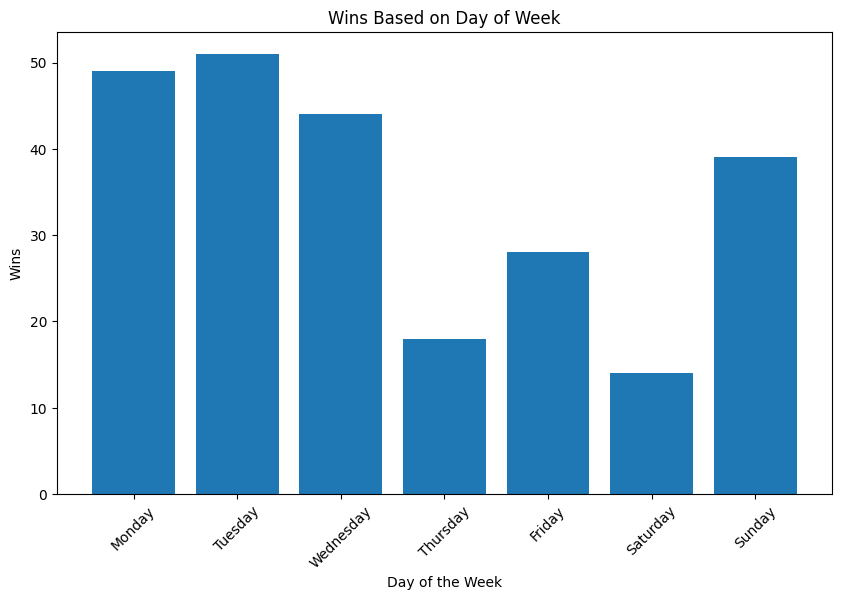

In [10]:
import matplotlib.pyplot as plt

# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate the sum of each time column and reorder them
time_cols = ['time_Friday', 'time_Monday', 'time_Saturday', 'time_Sunday', 'time_Thursday', 'time_Tuesday', 'time_Wednesday']
time_sums = hi[time_cols].sum()
time_sums_ordered = time_sums.loc[[f'time_{day}' for day in day_order]]

# Remove the 'time_' prefix from column names
time_labels = [col.replace('time_', '') for col in time_sums_ordered.index]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(time_labels, time_sums_ordered)
plt.title('Wins Based on Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Wins')
plt.xticks(rotation=45)
plt.show()


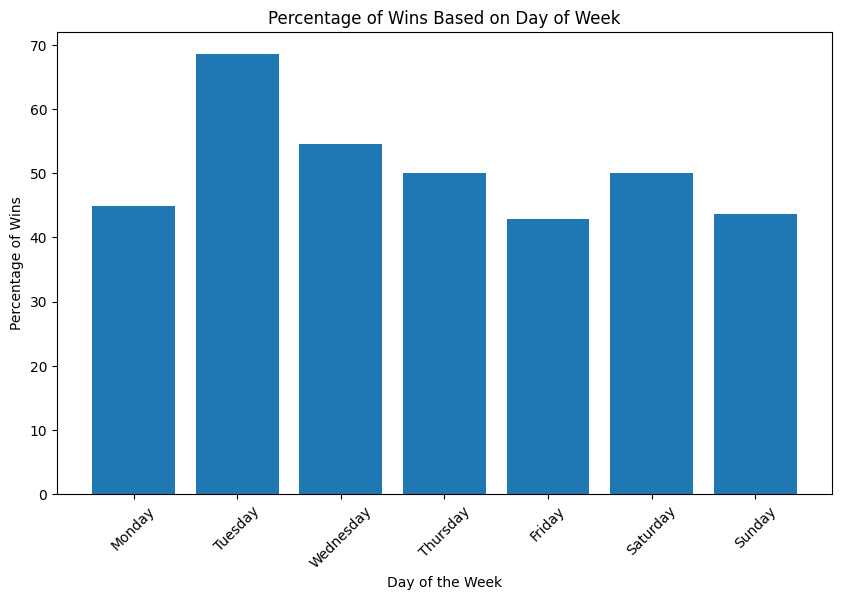

In [11]:
import matplotlib.pyplot as plt

# Define the order of days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate the percentage of 'True' values for each day
win_percentages = {}
for day in day_order:
    total_count = len(hi[hi[f'time_{day}'] == 1])
    true_count = len(hi[(hi[f'time_{day}'] == 1) & (hi['win'] == True)])
    win_percentages[day] = (true_count / total_count) * 100 if total_count > 0 else 0

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(win_percentages.keys(), win_percentages.values())
plt.title('Percentage of Wins Based on Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage of Wins')
plt.xticks(rotation=45)
plt.show()

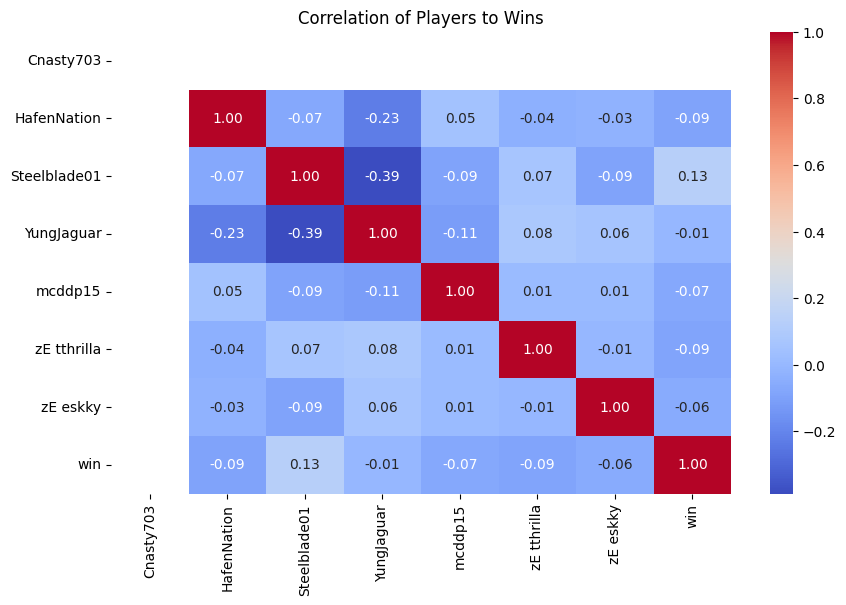

In [12]:
import seaborn as sns

# Select the columns of interest
columns_of_interest = ['Cnasty703', 'HafenNation', 'Steelblade01', 'YungJaguar', 'mcddp15', 'zE tthrilla', 'zE eskky', 'win']
hi_subset = hi[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = hi_subset.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Players to Wins')
plt.show()

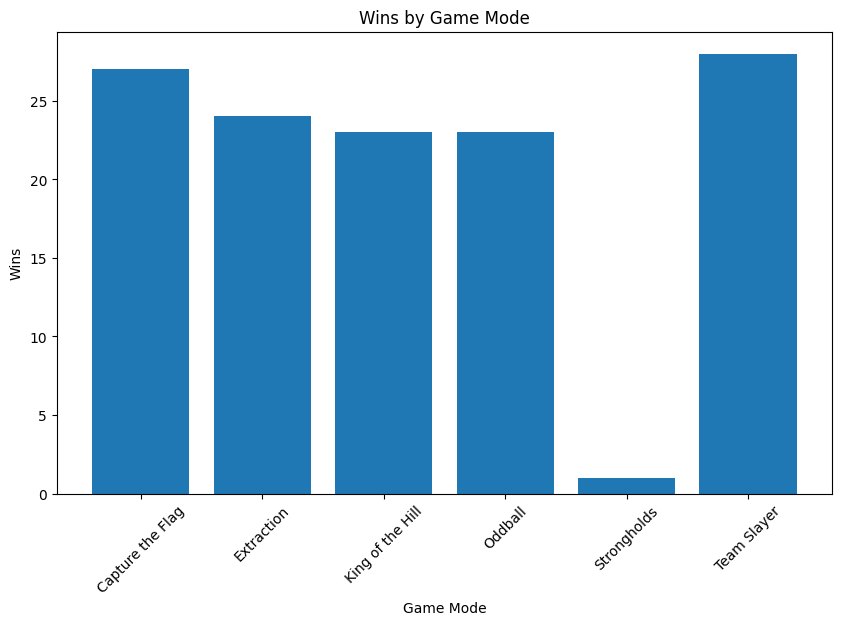

In [13]:
import matplotlib.pyplot as plt

# Select the columns of interest
gamemode_cols = ['gamemode_Capture the Flag', 'gamemode_Extraction', 'gamemode_King of the Hill',
                 'gamemode_Oddball', 'gamemode_Strongholds', 'gamemode_Team Slayer']
win_column = 'win'

# Calculate the sum of wins for each game mode
win_counts = hi.groupby(gamemode_cols)[win_column].sum().reset_index()

# Modify the labels
gamemode_labels = [col.split('_')[1] for col in gamemode_cols]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(win_counts.index, win_counts[win_column])
plt.xticks(win_counts.index, gamemode_labels, rotation=45)
plt.title('Wins by Game Mode')
plt.xlabel('Game Mode')
plt.ylabel('Wins')
plt.show()

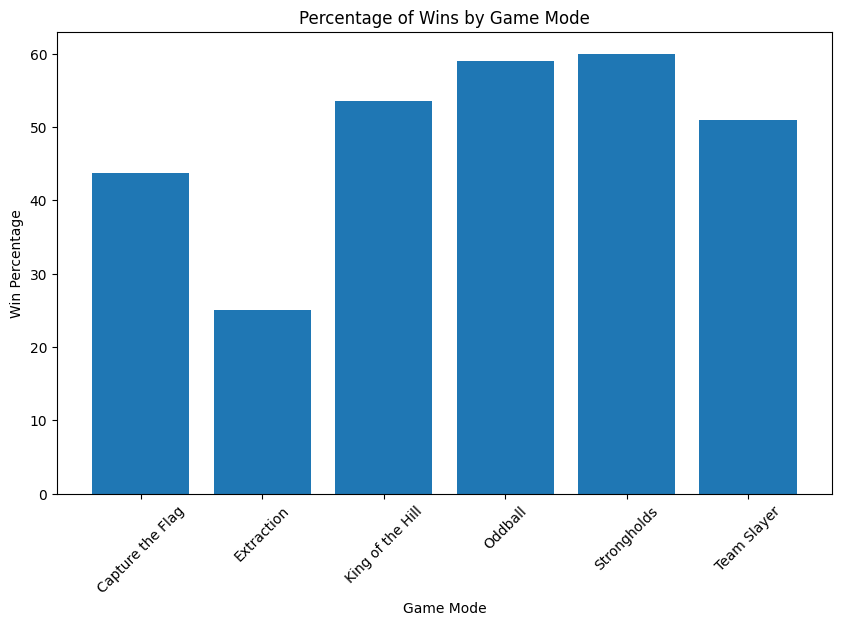

In [14]:
import matplotlib.pyplot as plt

# Select the columns of interest
gamemode_cols = ['gamemode_Capture the Flag', 'gamemode_Extraction', 'gamemode_King of the Hill',
                 'gamemode_Oddball', 'gamemode_Strongholds', 'gamemode_Team Slayer']
win_column = 'win'

# Calculate the percentage of 'True' values for each game mode
win_percentages = {}
for col in gamemode_cols:
    total_count = len(hi[hi[col] == 1])
    true_count = len(hi[(hi[col] == 1) & (hi[win_column] == True)])
    win_percentages[col] = (true_count / total_count) * 100 if total_count > 0 else 0

# Remove the 'gamemode_' prefix from each bar label
gamemode_labels = [col.split('_')[1] for col in gamemode_cols]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(gamemode_labels, win_percentages.values())
plt.title('Percentage of Wins by Game Mode')
plt.xlabel('Game Mode')
plt.ylabel('Win Percentage')
plt.xticks(rotation=45)
plt.show()

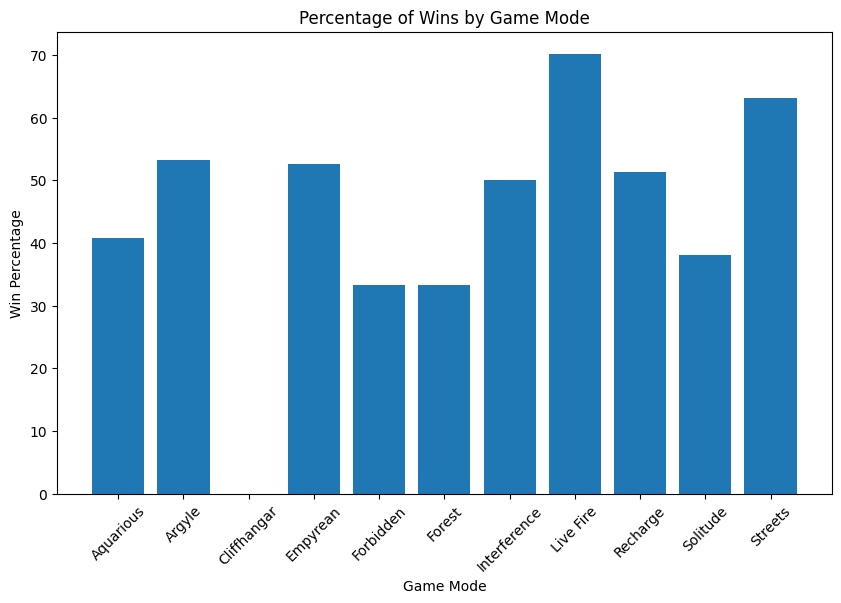

In [15]:
# Select the columns of interest
gamemode_cols = ['game_map_Aquarious', 'game_map_Argyle', 'game_map_Cliffhangar',
                 'game_map_Empyrean', 'game_map_Forbidden', 'game_map_Forest', 'game_map_Interference',
                 'game_map_Live Fire', 'game_map_Recharge', 'game_map_Solitude',
                 'game_map_Streets']
win_column = 'win'

# Calculate the percentage of 'True' values for each game mode
win_percentages = {}
for col in gamemode_cols:
    total_count = len(hi[hi[col] == 1])
    true_count = len(hi[(hi[col] == 1) & (hi[win_column] == True)])
    win_percentages[col] = (true_count / total_count) * 100 if total_count > 0 else 0

# Remove the 'gamemode_' prefix from each bar label
gamemode_labels = [col.split('_')[2] for col in gamemode_cols]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(gamemode_labels, win_percentages.values())
plt.title('Percentage of Wins by Game Mode')
plt.xlabel('Game Mode')
plt.ylabel('Win Percentage')
plt.xticks(rotation=45)
plt.show()